In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb

from scipy import stats

from h3 import latlng_to_cell


import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

ModuleNotFoundError: No module named 'h3'

In [222]:
housing_df = pd.read_csv("/Users/codexplore/Developer/repos/machine-learning-101/data/common_datasets/housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [223]:
housing_df["rooms_per_house"] = housing_df["total_rooms"] / housing_df["households"]
housing_df["bedrooms_ratio"] = housing_df["total_bedrooms"] / housing_df["total_rooms"]
housing_df["people_per_house"] = housing_df["population"] / housing_df["households"]


In [225]:
housing_df = housing_df[~(housing_df["median_house_value"] > 500_000)]

In [226]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = housing_df.drop("median_house_value", axis=1)
y = housing_df["median_house_value"]

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X["income_cat"], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.drop(["income_cat"], axis=1)
X_test = X_test.drop(["income_cat"],axis=1)

In [287]:
def detect_column_type(df, target_col=None):
    if target_col:
        df = df.drop(target_col, axis=1)
    # Select numeric columns only
    numerical_cols = [cname for cname in df.select_dtypes(include=np.number).columns]
    # print(f"Numerical Features  : {numerical_cols}")
    # Categorical columns in the training data
    categorical_cols = [col for col in df.select_dtypes(exclude=np.number).columns]
    return numerical_cols, categorical_cols

def preprocess_data(X):
    # Convert categorical columns to 'category' dtype as required by lgb.Dataset
    _, categorical_cols = detect_column_type(X_train)
    for col in categorical_cols:
        X[col] = X[col].astype("category")
    return X

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)


In [306]:
X_train.shape, X_test.shape

((15740, 11), (3935, 11))

In [320]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train, enable_categorical=True) 
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test, enable_categorical=True) 

# Define hyperparameters
params = {"objective": "reg:squarederror", 
          "tree_method": "hist" # gpu_hist to enable GPU 
}

# Uses xgb.train instead of XGBRegressor, making it compatible with DMatrix.
xgb_r = xgb.train(params = params, 
                  dtrain = train_dmatrix,
                  num_boost_round = 1000 # for number of boosting rounds. Internally, XGBoost minimizes the loss function RMSE in small incremental rounds 
) 


In [321]:
# ===== 4. Make Predictions (Exponentiate back) =====
y_pred = xgb_r.predict(test_dmatrix)
print(root_mean_squared_error(y_test, y_pred)) # 41602.84279031341

41602.84279031341


In [316]:
results = xgb.cv(
   params, train_dmatrix,
   num_boost_round=1000,
   nfold=5,
   early_stopping_rounds=20
)
results.tail()



,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
124,0.107134,0.001019,0.221230,0.002127
125,0.106793,0.001078,0.221120,0.002066
126,0.106343,0.000998,0.221091,0.002098
127,0.105839,0.000927,0.221055,0.002038
128,0.105318,0.000924,0.220931,0.002135


In [317]:
# It has the same number of rows as the number of boosting rounds
# Each row is the average metrics of all splits (folds) for that round. 
best_num_boost_round = results.shape[0]
best_rmse = results['test-rmse-mean'].min()
print(best_num_boost_round, best_rmse) # 41602.84279031341

129 0.22093137245957903


In [318]:
def tune_xgb_hyperparameters(train_dmatrix, n_trial=50, n_startup_trials=10, metrics="rmse"):
    """Hyperparameter tuning for XGBoost Regressor using Optuna and DMatrix."""

    # Default parameters (can be overridden by tuning)
    default_params = {
        "objective": "reg:squarederror",  # Regression objective
        "num_boost_round": 3000,
        "early_stopping_rounds": 10,
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": 0,
        #"subsample": 0.8,
        #"learning_rate": 0.300000012,
        #"max_depth": 6,
        #"min_child_weight": 5,
    }

    def objective(trial):
        """Objective function for Optuna hyperparameter tuning."""
        tuning_params = {
            #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
            #"max_depth": trial.suggest_int("max_depth", 3, 10),
            #"min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            # "gamma": trial.suggest_float("gamma", 0.0, 1.0),
            # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            # "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 1.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 1.0, log=True),
        }
        params = {**default_params, **tuning_params}

        # # Cross-validation setup
        # kf = KFold(n_splits=5, shuffle=True, random_state=42)
        # rmse_scores = []

        # for train_idx, val_idx in kf.split(X_train):
        #     # Create DMatrix for train and validation sets
        #     dtrain = xgb.DMatrix(X_train.iloc[train_idx], label=y_train.iloc[train_idx], enable_categorical=True)
        #     dvalid = xgb.DMatrix(X_train.iloc[val_idx], label=y_train.iloc[val_idx], enable_categorical=True)

        #     evals = [(dtrain, "train"), (dvalid, "valid")]

        #     # Train model with early stopping
        #     model = xgb.train(
        #         params=params,
        #         dtrain=dtrain,
        #         num_boost_round=1000,  # Set a large number, early stopping will stop it
        #         evals=evals,
        #         early_stopping_rounds=default_params["early_stopping_rounds"],
        #         verbose_eval=False
        #     )

        #     # Predict on validation set
        #     y_pred = model.predict(dvalid)
        #     rmse = root_mean_squared_error(y_pred, y_train.iloc[val_idx])
        #     rmse_scores.append(rmse)
        
        cv_results = xgb.cv(
            params=params,
            dtrain=train_dmatrix,
            num_boost_round=default_params["num_boost_round"],
            nfold=5,
            stratified=False,
            early_stopping_rounds=default_params["early_stopping_rounds"],
            metrics=metrics,
            seed=42,
            verbose_eval=False,
            callbacks=None,
        )

        # Get the fold with the **lowest test-rmse-mean**
        best_num_boost_round = len(cv_results)
        #print(cv_results)
        best_rmse = cv_results[f"test-{metrics}-mean"].min()

        # Save attributes to study
        print(f"🔹 Best number of boosting rounds: {best_num_boost_round}")
        trial.set_user_attr("best_num_boost_round", best_num_boost_round)
        

        return best_rmse # Optuna minimizes this metric

    def callback(study: optuna.study, trial: optuna.Trial):
        # Checks if the current trial is the best trial 
        if study.best_trial.number == trial.number:
            # Saves the best number of boosting rounds (best_num_boost_round) as a study attribute
            # This ensures that after all trials are completed, the study retains the best boosting round count.
            study.set_user_attr(
                key="best_num_boost_round",
                value=trial.user_attrs["best_num_boost_round"],
            )
    # Optuna study
    study = optuna.create_study(
        direction="minimize",  # We want to minimize RMSE
         # uses Bayesian Optimization to sample promising hyperparameter sets based on past trials.
        sampler=optuna.samplers.TPESampler(seed=42, 
                                           # The first n_startup_trials use random search (to explore different regions of the parameter space).
                                           n_startup_trials=n_startup_trials),
    )
    study.optimize(objective, n_trials=n_trial, callbacks=[callback])
    
    best_num_boost_round = study.user_attrs["best_num_boost_round"]

    # Extract best params
    best_params = study.best_params
    # this is to merge the default_params & best_params after the study
    for k, v in default_params.items():
        if k not in ("early_stopping_rounds", "verbosity"):
            # overwrite the best_param with default valeus
            best_params[k] = v
        if k == "num_boost_round":
            best_params["num_boost_round"] = best_num_boost_round
    print(f"✅ Final best number of boosting rounds: {best_num_boost_round}")

    return best_params

# Example usage (assuming X_train, y_train are defined)
best_xgb_params = tune_xgb_hyperparameters(train_dmatrix, n_trial=10, n_startup_trials=5, metrics="rmse")


[I 2025-04-20 16:55:42,772] A new study created in memory with name: no-name-acdb3f2c-7e98-4335-91d9-ac9aa8169646
[I 2025-04-20 16:55:46,343] Trial 0 finished with value: 0.22214198615434885 and parameters: {'reg_alpha': 0.0007459343285726547, 'reg_lambda': 0.5669849511478852}. Best is trial 0 with value: 0.22214198615434885.


🔹 Best number of boosting rounds: 120


[I 2025-04-20 16:55:49,715] Trial 1 finished with value: 0.22505698613618078 and parameters: {'reg_alpha': 0.04570563099801452, 'reg_lambda': 0.009846738873614562}. Best is trial 0 with value: 0.22214198615434885.


🔹 Best number of boosting rounds: 112


[I 2025-04-20 16:55:53,218] Trial 2 finished with value: 0.2240279498185036 and parameters: {'reg_alpha': 6.0268891286825045e-05, 'reg_lambda': 6.025215736203858e-05}. Best is trial 0 with value: 0.22214198615434885.


🔹 Best number of boosting rounds: 118


[I 2025-04-20 16:55:56,481] Trial 3 finished with value: 0.2228529707317865 and parameters: {'reg_alpha': 1.951722464144947e-05, 'reg_lambda': 0.21423021757741062}. Best is trial 0 with value: 0.22214198615434885.


🔹 Best number of boosting rounds: 110


[I 2025-04-20 16:56:00,642] Trial 4 finished with value: 0.22349923330049096 and parameters: {'reg_alpha': 0.010129197956845729, 'reg_lambda': 0.03470266988650412}. Best is trial 0 with value: 0.22214198615434885.


🔹 Best number of boosting rounds: 142


[I 2025-04-20 16:56:05,069] Trial 5 finished with value: 0.2206624569755471 and parameters: {'reg_alpha': 0.0007453892933860188, 'reg_lambda': 0.4616469809415221}. Best is trial 5 with value: 0.2206624569755471.


🔹 Best number of boosting rounds: 147


[I 2025-04-20 16:56:09,211] Trial 6 finished with value: 0.21853654425972016 and parameters: {'reg_alpha': 0.7041830285016019, 'reg_lambda': 0.00025780533599902494}. Best is trial 6 with value: 0.21853654425972016.


🔹 Best number of boosting rounds: 127


[I 2025-04-20 16:56:13,889] Trial 7 finished with value: 0.21908124995845246 and parameters: {'reg_alpha': 0.8307587298143325, 'reg_lambda': 0.0002148184156076816}. Best is trial 6 with value: 0.21853654425972016.


🔹 Best number of boosting rounds: 146


[I 2025-04-20 16:56:17,940] Trial 8 finished with value: 0.21731482448681844 and parameters: {'reg_alpha': 0.7334834973038374, 'reg_lambda': 0.0008963480709755238}. Best is trial 8 with value: 0.21731482448681844.


🔹 Best number of boosting rounds: 126


[I 2025-04-20 16:56:21,383] Trial 9 finished with value: 0.22174859392080673 and parameters: {'reg_alpha': 0.08282245617333767, 'reg_lambda': 1.1522742262755006e-05}. Best is trial 8 with value: 0.21731482448681844.


🔹 Best number of boosting rounds: 111
✅ Final best number of boosting rounds: 126


In [294]:
best_xgb_params

{'reg_alpha': 0.00019935702522627045,
 'reg_lambda': 0.7660387097579393,
 'objective': 'reg:squarederror',
 'num_boost_round': 119,
 'random_state': 42,
 'n_jobs': -1}

In [295]:
final_model = xgb.train(params=best_xgb_params, dtrain = train_dmatrix)
y_pred = final_model.predict(test_dmatrix)
print(root_mean_squared_error(y_test, y_pred))

48634.94378241377


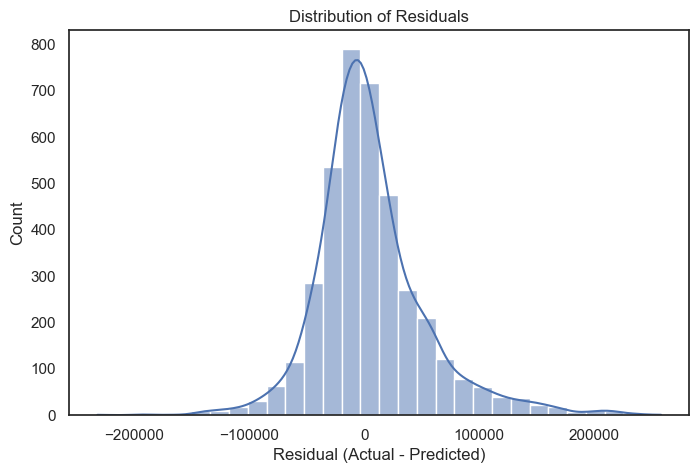

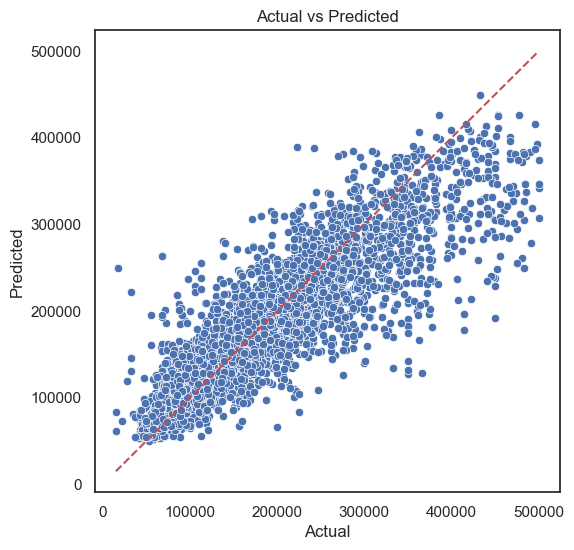

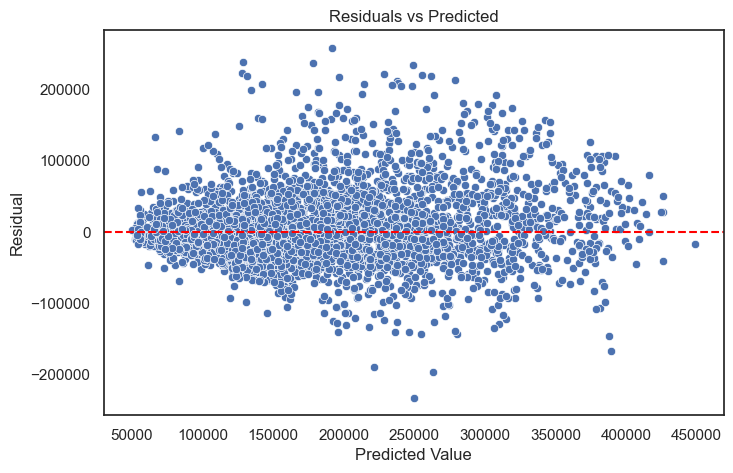

Top 10 worst predictions:
         Actual      Predicted       Residual  Absolute Residual  \
4623   450000.0  191763.453125  258236.546875      258236.546875   
12429  366700.0  128516.203125  238183.796875      238183.796875   
8315   414700.0  178230.640625  236469.359375      236469.359375   
140    483300.0  249193.765625  234106.234375      234106.234375   
5887    17500.0  249761.843750 -232261.843750      232261.843750   
7262   350000.0  127697.375000  222302.625000      222302.625000   
4265   450000.0  228689.281250  221310.718750      221310.718750   
15747  475000.0  255383.328125  219616.671875      219616.671875   
10491  480800.0  261571.234375  219228.765625      219228.765625   
458    350000.0  131756.515625  218243.484375      218243.484375   

       Percent Error  
4623        0.573859  
12429       0.649533  
8315        0.570218  
140         0.484391  
5887       13.272105  
7262        0.635150  
4265        0.491802  
15747       0.462351  
10491       0.4559

In [296]:

# y_test: ground truth, y_pred: model prediction
residuals = y_test - y_pred
abs_residuals = np.abs(residuals)
percent_error = abs_residuals / np.abs(y_test)

error_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Residual": residuals,
    "Absolute Residual": abs_residuals,
    "Percent Error": percent_error
})

# 1. Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# 2. Predicted vs Actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# 3. Residual vs Predicted (look for heteroscedasticity)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.show()

# 4. Identify worst predictions
worst_cases = error_df.sort_values(by="Absolute Residual", ascending=False).head(10)
print("Top 10 worst predictions:")
print(worst_cases)


In [ ]:
# These are true outliers that might not follow the pattern the model has learned.
X_test.loc[5887, :]

longitude               -118.33
latitude                  34.15
housing_median_age         39.0
total_rooms               493.0
total_bedrooms            168.0
population                259.0
households                138.0
median_income            2.3667
ocean_proximity       <1H OCEAN
rooms_per_house        3.572464
bedrooms_ratio         0.340771
people_per_house       1.876812
Name: 5887, dtype: object

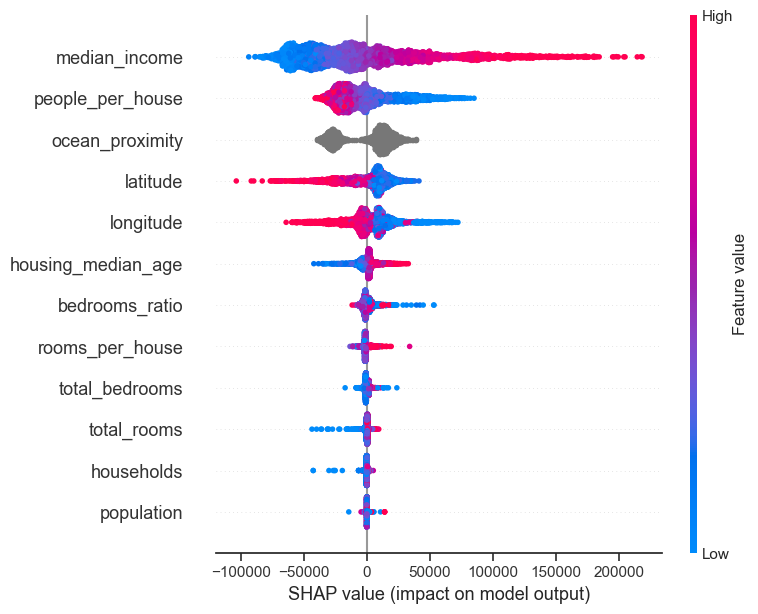

In [283]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(final_model)
shap_values = explainer(test_dmatrix)

shap.summary_plot(shap_values, X_test)


In [323]:
# compute a 95% confidence interval for the generalization error using scipy.stats.bootstrap().
# Defines a helper function to compute RMSE from squared errors.
def rmse_func(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (y_pred - y_test) ** 2
# It performs bootstrap resampling on the squared_errors data (i.e., repeatedly samples with replacement).
# Each resample is used to compute an RMSE via rmse_func function.
boot_result = stats.bootstrap([squared_errors], rmse_func,
                              confidence_level=confidence, random_state=42)
# After many iterations (by default, 9999), it calculates the confidence interval of the RMSE distribution.
rmse_lower, rmse_upper = boot_result.confidence_interval

print(f"95% CI for RMSE: [{rmse_lower:.4f}, {rmse_upper:.4f}]")


95% CI for RMSE: [40025.2298, 43221.5031]


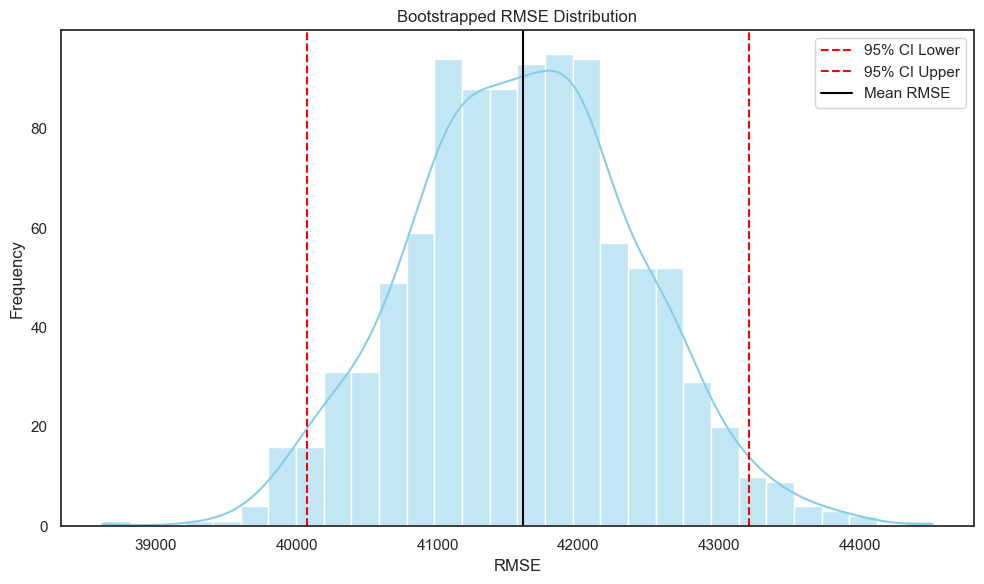

In [324]:

n_iterations = 1000

rng = np.random.default_rng(seed=42)

rmse_samples = []

n = len(squared_errors)
for _ in range(n_iterations):
    # Sample with replacement
    sample = rng.choice(squared_errors, size=n, replace=True)
    rmse_sample = rmse_func(sample)
    rmse_samples.append(rmse_sample)

# Compute confidence interval
lower_bound = np.percentile(rmse_samples, (1 - confidence) / 2 * 100)
upper_bound = np.percentile(rmse_samples, (1 + confidence) / 2 * 100)

# 📈 Plotting the RMSE distribution
plt.figure(figsize=(10, 6))
sns.histplot(rmse_samples, bins=30, kde=True, color="skyblue")
plt.axvline(lower_bound, color="red", linestyle="--", label=f"{int(confidence*100)}% CI Lower")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"{int(confidence*100)}% CI Upper")
plt.axvline(np.mean(rmse_samples), color="black", linestyle="-", label="Mean RMSE")
plt.title("Bootstrapped RMSE Distribution")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
